In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [2]:
d=pd.read_csv('name.csv')

In [29]:
# !pip install gradio
# !pip install gradio

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/60 [00:00<?, ?it/s]

Embeddings shape: (59029, 768)


  0%|          | 0/8 [00:00<?, ?it/s]

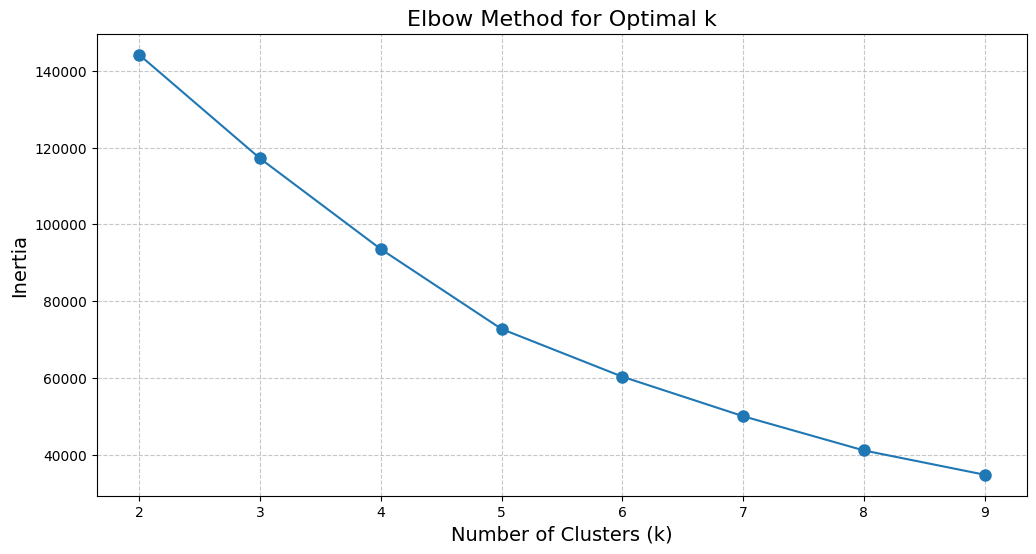

In [28]:
# Load the advanced BERT model - I chose RoBERTa as it performs better than the original DistilBERT
# RoBERTa-base is an improvement over BERT that outperforms it on most tasks with roughly the same model size
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModel.from_pretrained('roberta-base').cuda()  # Move model to GPU

# Verify data is loaded
# Assuming you have a DataFrame called 'd' containing a 'name' column
# Replace this with your data loading code if needed

# Data cleaning
def clean_text(text):
    # Remove repeated strings and unhelpful symbols
    text = re.sub(r'\s*,,,\s*|\s*,,\s*', ' ', text)
    text = re.sub(r'\\r\\n', ' ', text)
    text = re.sub(r'-\s*with\s*Special\s*Offers', '', text)
    text = re.sub(r'\s{2,}', ' ', text)  # Replace multiple spaces with single space
    return text.strip()

# Apply cleaning to data
d['clean_name'] = d['name'].apply(clean_text)

# Extract BERT embeddings using batches and GPU acceleration
def get_roberta_embeddings(texts, model, tokenizer, batch_size=16):
    # Put model in evaluation mode
    model.eval()
    all_embeddings = []

    # Process data in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Encode texts
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True,
                                  return_tensors='pt', max_length=128)

        # Move data to GPU
        encoded_input = {k: v.cuda() for k, v in encoded_input.items()}

        # Get model outputs
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Use average of last hidden layer for better text representation
        # This is often better than just using the [CLS] token
        token_embeddings = model_output.last_hidden_state
        attention_mask = encoded_input['attention_mask']

        # Calculate mean embeddings using attention mask
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)

        # Get the average
        batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
        all_embeddings.append(batch_embeddings)

    # Combine all batches
    embeddings_array = np.vstack(all_embeddings)
    return embeddings_array

# Extract embeddings
X = get_roberta_embeddings(d['clean_name'].tolist(), model, tokenizer, batch_size=1000)
print(f"Embeddings shape: {X.shape}")

# Apply Elbow method to determine optimal number of clusters
inertia_values = []
k_range = range(2, 10)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(k_range, inertia_values, 'o-', markersize=8)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
d['cluster'] = kmeans.fit_predict(X)


In [24]:
d['cluster'].value_counts()

,count
cluster,
0,31683
1,11336
3,10162
4,3313
2,2535


In [23]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModel



cluster_names = {
    0: "Entry-Level and Kids Fire Tablets",
    1: "Batteries, Laptop Gear, and Basic Accessories",
    2: "Streaming Devices and E-Readers",
    3: "Advanced E-Readers and Smart Assistants",
    4: "Echo Speakers and Smart Home Hubs"
}

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        output = model(**inputs)
    token_embeddings = output.last_hidden_state
    attention_mask = inputs['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    embedding = (sum_embeddings / sum_mask).cpu().numpy()
    return embedding

def predict_category(name):
    embedding = get_embedding(name)
    cluster = kmeans.predict(embedding)[0]
    category = cluster_names.get(cluster, "Unknown")
    return f"Category: {category}"

gr.Interface(
    fn=predict_category,
    inputs=gr.Textbox(label="Enter Product Name"),
    outputs=gr.Textbox(label="Predicted Category"),
    title="🧠 Product Categorizer (RoBERTa + KMeans)",
    allow_flagging="never"
).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2aa07588c42b69105c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [25]:
import joblib

joblib.dump(kmeans, "kmeans_model.pkl")



['kmeans_model.pkl']

In [ ]:
np.save("product_embeddings.npy", X)
tokenizer.save_pretrained("roberta_tokenizer")
model.save_pretrained("roberta_model")
